# Airbnb New User Bookings

by Semin Kim. Last Update: 2017/01/07.

(joint with Isaac Solomon from Brown University)

## We first explore user and session data individually:

User Data
- 210K users with 16 features, such as age, gender, account create date, and device used. 
- 87.5% of bookings are US/NDF(no booking). 
- 40% of age are missing and have some outlier having >1000 age.
- Users with missing 'age' information significantly less likely to book.
- Similarly to 'missing age', users with 'missing gender' information significantly less likely to book.
- For users who booked,  
    42% of users booked in a day
    63% of users booked in a week 
    75% of users booked in a month
    82% of users booked in 3 months
    since they joined. 
    
Session Data
- 10M data of users for 2014.
- Jan-Jun: train users, Jul-Sep: test users. 
- each row is a single action by a user, with 3 hierarchical descriptions of action (action type - action detail - action)
  with seconds spent. 
- 11 action types, 156 action details, and 360 actions. 
- 65K out of 210K train users have session data. 
- Almost all(99.3%) of 62K test users have session data. 
- ~10% of data have missing information.  

## Then we merge user and session data as follows:
- We add 'action' activities using word vectors by counting the number of each action. 
  (similar to text analysis by word-counting vector)
- We also keep the total second for each action, by creating another 360 word vector of total seconds for each action. 
- Therefore, we add 720 feature vector for each 650K users. 
- Finally, we have 650K x 720 dimensional dataframe and save it for future analysis. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('train_users_2.csv')
df_s = pd.read_csv('sessions.csv')

In [3]:
df.shape

(213451, 16)

In [4]:
df_s.shape

(10567737, 6)

In [5]:
df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
df_s.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


# 1. Explore User Information

In [7]:
df.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

## country of destination (booking)

In [8]:
dest_cnt = df['country_destination'].value_counts()
dest_cnt_percent = dest_cnt/(dest_cnt.sum())*100
dest_cnt_percent

NDF      58.347349
US       29.222632
other     4.728954
FR        2.353233
IT        1.328174
GB        1.088774
ES        1.053638
CA        0.669006
DE        0.497070
NL        0.356991
AU        0.252517
PT        0.101663
Name: country_destination, dtype: float64

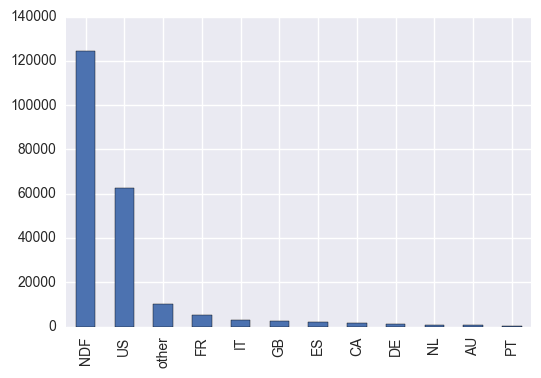

In [9]:
dest_cnt.plot(kind='bar')

- 87.5% of bookings are US/NDF(no booking). 
- We first model US/NDF binary classfication.

In [10]:
df = df[df.country_destination.isin(['NDF', 'US'])]

In [11]:
df.shape

(186919, 16)

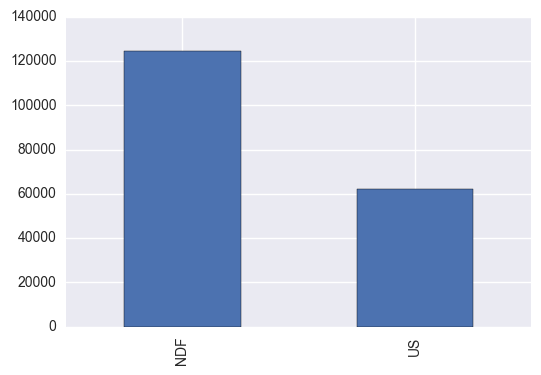

In [12]:
dest_cnt = df.country_destination.value_counts()
dest_cnt.plot(kind='bar')

In [13]:
dest_cnt_percent = dest_cnt/dest_cnt.sum()*100
dest_cnt_percent

NDF    66.629396
US     33.370604
Name: country_destination, dtype: float64

## age

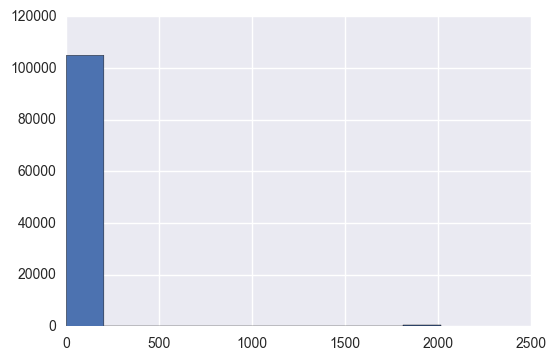

In [14]:
df.age.hist()

- 40% of age are missing. 
- We also see some outliers: age~2000. 

In [15]:
df.age.fillna(1000, inplace=True)
df['ageCat'] = pd.cut(df['age'], 
                        bins=[0, 18, 30, 60, 100, 10000])

In [16]:
df['ageCat'].value_counts()

(100, 10000]    83338
(30, 60]        61229
(18, 30]        36624
(60, 100]        5049
(0, 18]           679
Name: ageCat, dtype: int64

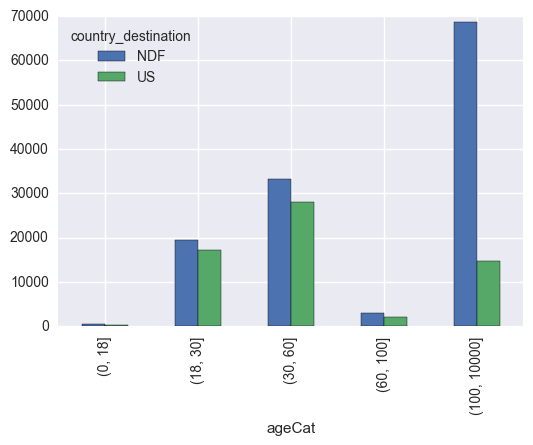

In [17]:
df.groupby(['ageCat', 'country_destination']).size().unstack().plot(kind='bar')

- Users with missing 'age' information much more likely not to book.

## gender

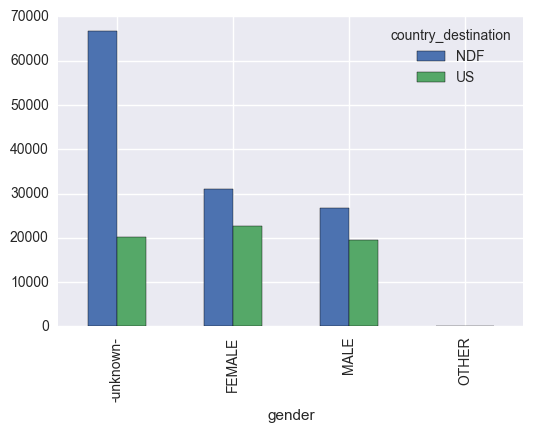

In [18]:
df.groupby(['gender', 'country_destination']).size().unstack().plot(kind='bar')

- Similarly to 'missing age', users with 'missing gender' information much more likely not to book.

## time to book since account creation. 

In [19]:
df['date_account_created'] = pd.to_datetime(df['date_account_created'], format='%Y-%m-%d')
df['date_first_booking'] = pd.to_datetime(df['date_first_booking'], format='%Y-%m-%d')
df['create_year'] = df.date_account_created.apply(lambda x: x.year)
df['create_month'] = df.date_account_created.apply(lambda x: x.month)

In [20]:
def timedelta_to_day(time_delta):
    if pd.notnull(time_delta):
        return time_delta.days
    return np.nan

df['time_create_to_book'] = (df['date_first_booking']-df['date_account_created']).apply(timedelta_to_day)

In [21]:
df['time_create_to_book'].isnull().sum()

124543

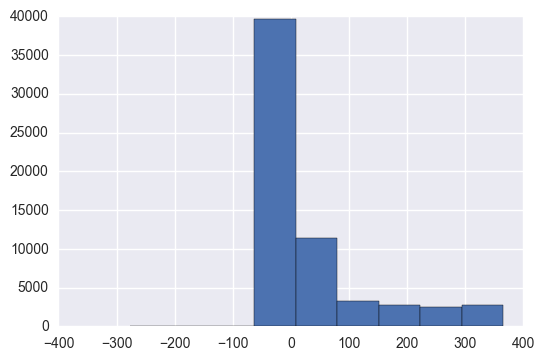

In [22]:
df['time_create_to_book'].hist()

In [23]:
(df.time_create_to_book < 0).sum()

21

- We see some outliers, with a negative value for time_create_to_book

In [24]:
df.shape

(186919, 20)

In [25]:
df = df[~(df.time_create_to_book < 0)]

In [26]:
df.shape

(186898, 20)

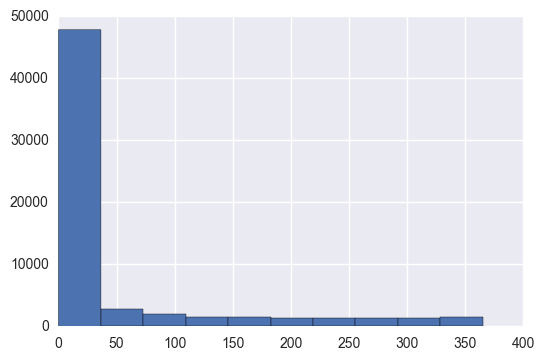

In [27]:
df['time_create_to_book'].hist()

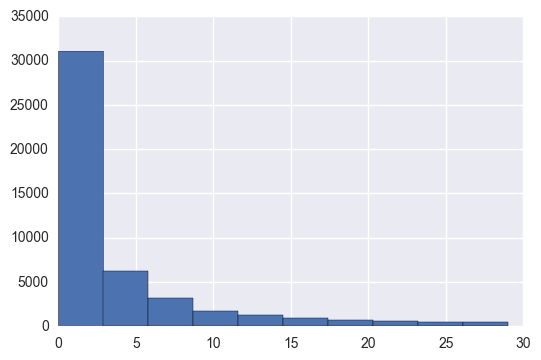

In [28]:
df[df['time_create_to_book'] < 30]['time_create_to_book'].hist()

In [29]:
df[df['time_create_to_book'].notnull()].country_destination.value_counts()

US    62355
Name: country_destination, dtype: int64

In [30]:
df[df['time_create_to_book'].isnull()].country_destination.value_counts()

NDF    124543
Name: country_destination, dtype: int64

In [31]:
df['time_create_to_book_cat'] = pd.cut(df['time_create_to_book'], 
                        bins=[-0.1,1, 7, 30, 90,1000])

In [32]:
time_book_cnt = df['time_create_to_book_cat'].value_counts()
time_book_cnt_percent = time_book_cnt/time_book_cnt.sum()*100
time_book_cnt_percent

(-0.1, 1]     42.432844
(1, 7]        21.175527
(90, 1000]    17.174244
(7, 30]       11.939700
(30, 90]       7.277684
Name: time_create_to_book_cat, dtype: float64

For users who booked,  
- 42% booked in a day.
- 63% booked in a week. 
- 75% booked in a month
- 82% booked in 3 months
since they joined. 

# 2. Explore Session Data

In [33]:
df_s.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

- 10% of action_type and action_details are missing. 
- others are ~1% missing. 

In [34]:
len(df_s.action_type.unique())

11

In [35]:
df_s.action_type.value_counts()[:10]

view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

In [36]:
len(df_s.action_detail.unique())

156

In [37]:
df_s.action_detail.value_counts()[:10]

view_search_results            1776885
p3                             1376550
-unknown-                      1031141
wishlist_content_update         706824
user_profile                    656839
change_trip_characteristics     487744
similar_listings                364624
user_social_connections         336799
update_listing                  269779
listing_reviews                 269021
Name: action_detail, dtype: int64

In [38]:
len(df_s.action.unique())

360

In [39]:
df_s.action.value_counts()[:10]

show                     2768278
index                     843699
search_results            725226
personalize               706824
search                    536057
ajax_refresh_subtotal     487744
update                    365130
similar_listings          364624
social_connections        339000
reviews                   320591
Name: action, dtype: int64

## ID analysis

In [40]:
df.shape

(186898, 21)

In [41]:
ids_with_session = df[df.id.isin(df_s.user_id)].id
ids_with_session.shape

(65136,)

- 35% of users in train data are having session data. 
- This is because sesseion data are collected for users for 2014. 
- We first only use user data with session data. 

In [42]:
df_test = pd.read_csv('test_users.csv')

In [43]:
df_test.shape

(62096, 15)

In [44]:
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [45]:
ids_test_with_session = df_test[df_test.id.isin(df_s.user_id)].id
ids_test_with_session.shape

(61668,)

- 99.3% of test users have session data
- Therefore, we are safe to model using session data. 

In [46]:
df = df[df.id.isin(ids_with_session)]

In [47]:
df.shape

(65136, 21)

In [48]:
df_s = df_s[df_s.user_id.isin(ids_with_session)]

In [49]:
df_s.shape

(4733234, 6)

In [50]:
df.to_csv('train_users_with_session.csv', index=False)
df_s.to_csv('train_sessions.csv', index=False)

# 3. Combine User and Session Data

In [51]:
df = pd.read_csv('train_users_with_session.csv')
df_s = pd.read_csv('train_sessions.csv')

In [52]:
user_info = ['gender', 'ageCat','signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'signup_app', 'first_device_type', 'first_browser']
target = 'country_destination'

In [53]:
from sklearn.preprocessing import LabelEncoder
for col in user_info+[target]:
    df[col] = LabelEncoder().fit_transform(df[col].values)

In [54]:
import pyprind

def combineData(df_origin, df_s):
    
    df = df_origin.copy()
    
    col_name='action'
    col_idx = 1
    
    # extract unique action values 
    actions = [x if pd.notnull(x) else 'missing' for x in df_s[col_name].unique()]
    
    # add columns for each action values
    # 'bag-of-word' type model, with counting vectorization. 
    for x in actions:
        df[x] = 0
        df[x+'_sec'] = 0
        
    # for speed-up purpose, we use numpy values. 
    # compare to df.iterrows()
    df_v = df.values
    df_s_v = df_s.values

    hash_id_idx = {user_id:idx for idx, user_id in enumerate(df_v[:,0])}
    hash_action_idx = {col:idx for idx, col in enumerate(df.columns) if col in actions}
    
    n = df_s_v.shape[0]
    pbar = pyprind.ProgBar(n)
    for i in range(n):
        user_id = df_s_v[i,0]
        user_action = df_s_v[i,col_idx]
        user_action_sec = df_s_v[i,5]

        if pd.isnull(user_action):
            user_action = 'missing'
        if pd.isnull(user_action_sec):
            user_action_sec = 0

        user_idx = hash_id_idx[user_id]
        action_idx = hash_action_idx[user_action]
        df_v[user_idx, action_idx] += 1
        df_v[user_idx, action_idx+1] += user_action_sec

        pbar.update()
    
    df = pd.DataFrame(df_v, columns=df.columns)
    return df, actions

In [55]:
df2, actions = combineData(df, df_s)

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:23


In [56]:
df2.shape

(65136, 679)

In [57]:
df2.iloc[0:10,21:29]

,dashboard,dashboard_sec,create,create_sec,confirm_email,confirm_email_sec,show,show_sec
0,1,2739,1,0,1,115983,3,71673
1,0,0,4,617933,0,0,0,0
2,0,0,2,12952,1,274002,15,562785
3,0,0,1,0,1,1.37162e+06,0,0
4,1,1355,0,0,1,46262,0,0
5,0,0,1,0,0,0,14,242969
6,1,1832,1,8834,2,11658,81,337983
7,1,1136,0,0,1,342501,0,0
8,0,0,1,0,0,0,16,190245
9,0,0,1,0,0,0,0,0


In [58]:
df2.to_csv('train_user_session_merged.csv', index=False)
pd.Series(actions).to_csv('actions.csv', index=False)